In [50]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

import numpy as np
import pickle
from SlovotvirModel import run_model, summary_func
import matplotlib.pyplot as plt

In [7]:
RNG = np.random.default_rng(2023)

In [8]:
x = run_model((10, 0, 1))

### 0. Setup and training

In [9]:
def model_prior():
    """Generates a random draw from the joint prior."""

    a = RNG.uniform(0, 10)
    b = RNG.uniform(0, 10)
    t = RNG.lognormal(0, sigma=0.5)
    return np.array([a, b, t])

In [10]:
prior = Prior(prior_fun=model_prior, param_names=[r"a", r"b", r"t"])

In [11]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [12]:
simulator = Simulator(simulator_fun=run_model)

In [13]:
model = GenerativeModel(prior, simulator, name="SlovoTvir")

INFO:root:Performing 2 pilot runs with the SlovoTvir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


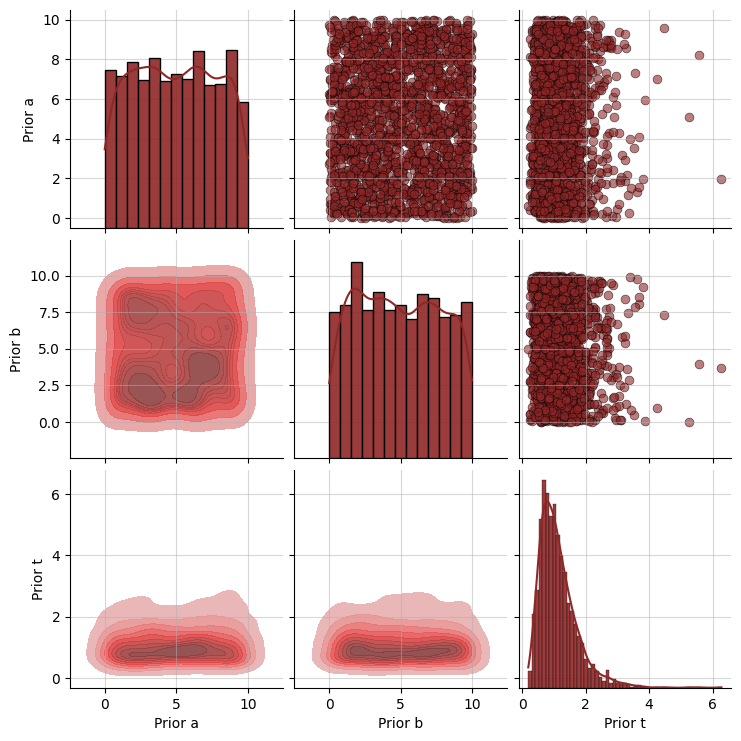

In [14]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [23]:
summary_net = SequenceNetwork()

In [24]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [25]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")

In [26]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [27]:
x = configure_input(model(1))

In [28]:
x['summary_conditions'].shape

(1, 100, 1)

In [29]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [30]:
amortizer.summary()

Model: "slovotvir_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inve  multiple                  292936    
 rtibleNetwork)                                                  
                                                                 
 sequence_network_1 (Sequen  multiple                  91178     
 ceNetwork)                                                      
                                                                 
Total params: 384114 (1.47 MB)
Trainable params: 384090 (1.47 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [32]:
%%time
_ = model(1000)

CPU times: user 52min 50s, sys: 17.5 s, total: 53min 8s
Wall time: 53min 32s


In [98]:
# pickle _
# pickle.dump(_, open('data.pickle', 'wb'))
unpickled = pickle.load(open('data.pickle', 'rb'))

In [99]:
%%time
history = trainer.train_offline(unpickled, epochs=30, batch_size=32, validation_sims=100)

INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.130


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.670


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 3.021


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.513


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 3.805


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.143


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 3.348


Training epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 3.311


Training epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 3.208


Training epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 2.735


Training epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 2.713


Training epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 2.660


Training epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 2.682


Training epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 2.756


Training epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 2.832


Training epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 2.624


Training epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 2.586


Training epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 3.026


Training epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 2.616


Training epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 2.631


Training epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 2.484


Training epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 2.467


Training epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 2.564


Training epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 2.450


Training epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 2.442


Training epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 2.413


Training epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 2.407


Training epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 2.414


Training epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 2.410


Training epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 2.410


CPU times: user 6min 33s, sys: 21.4 s, total: 6min 55s
Wall time: 6min 35s


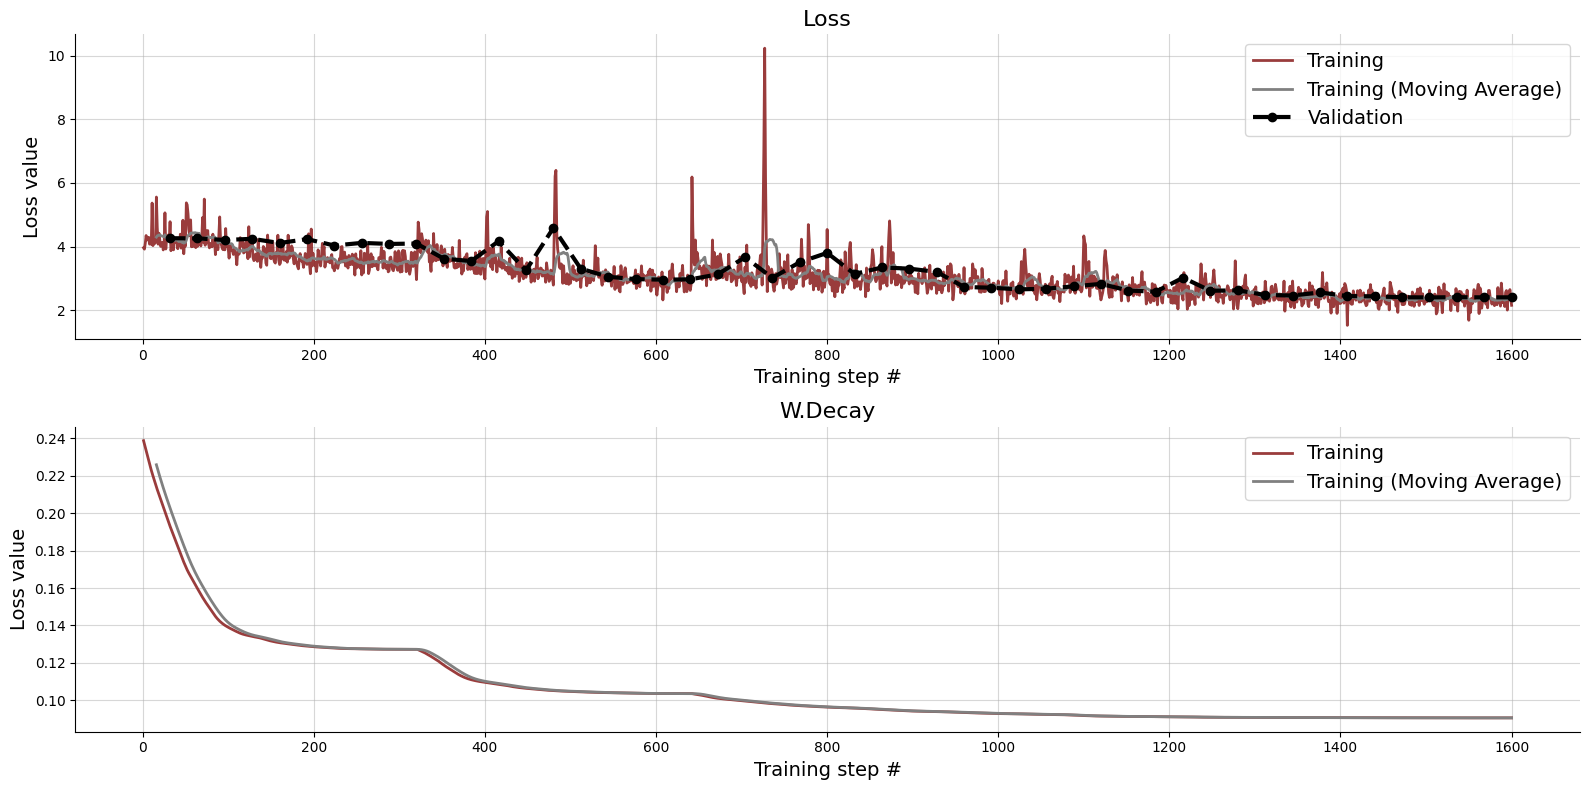

In [100]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

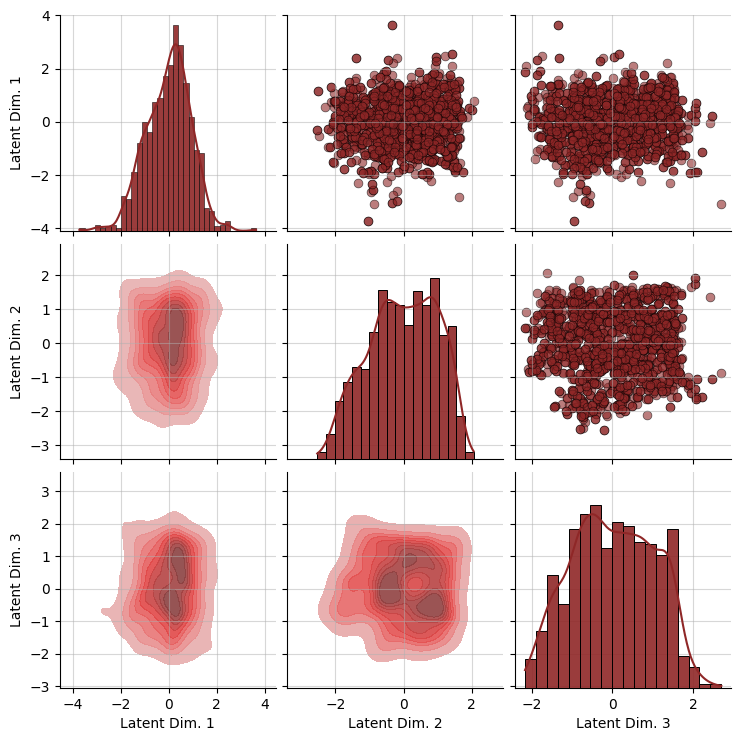

In [101]:
f = trainer.diagnose_latent2d()

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 19.                    Confidence intervals might be unreliable!


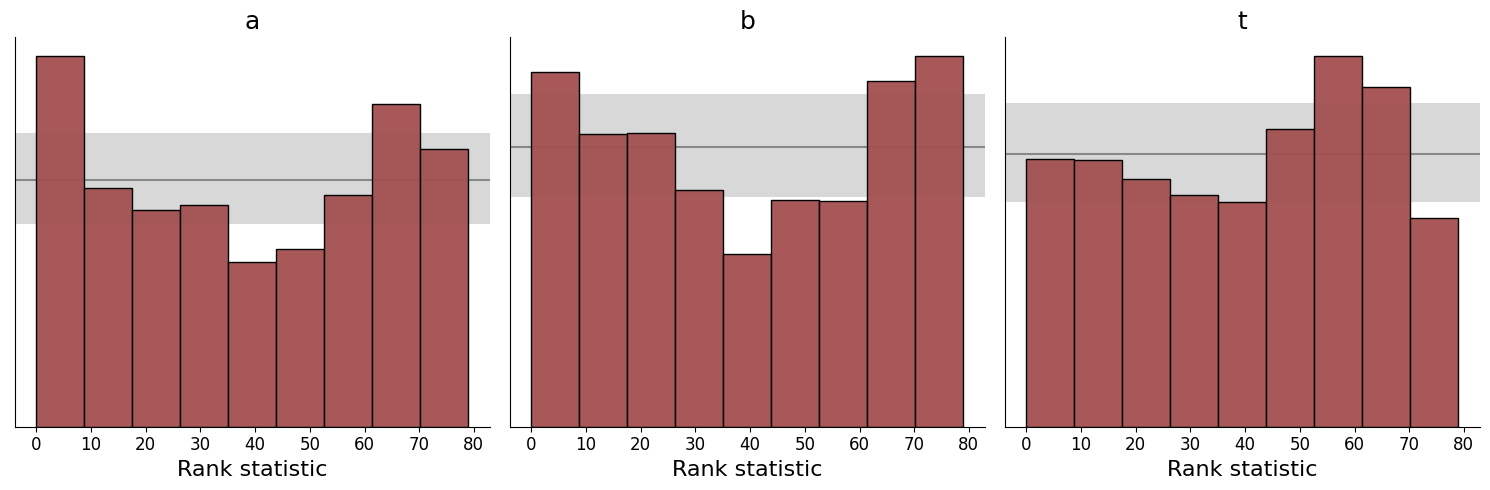

In [102]:
f = trainer.diagnose_sbc_histograms()

### 1. Posterior estimation:

In [113]:
with open('../data/true_likes.pkl', 'rb') as f:
    true_likes = pickle.load(f)

In [114]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(np.histogram(true_likes, bins=100)[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [115]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({"summary_conditions": obs_data}, 500)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds

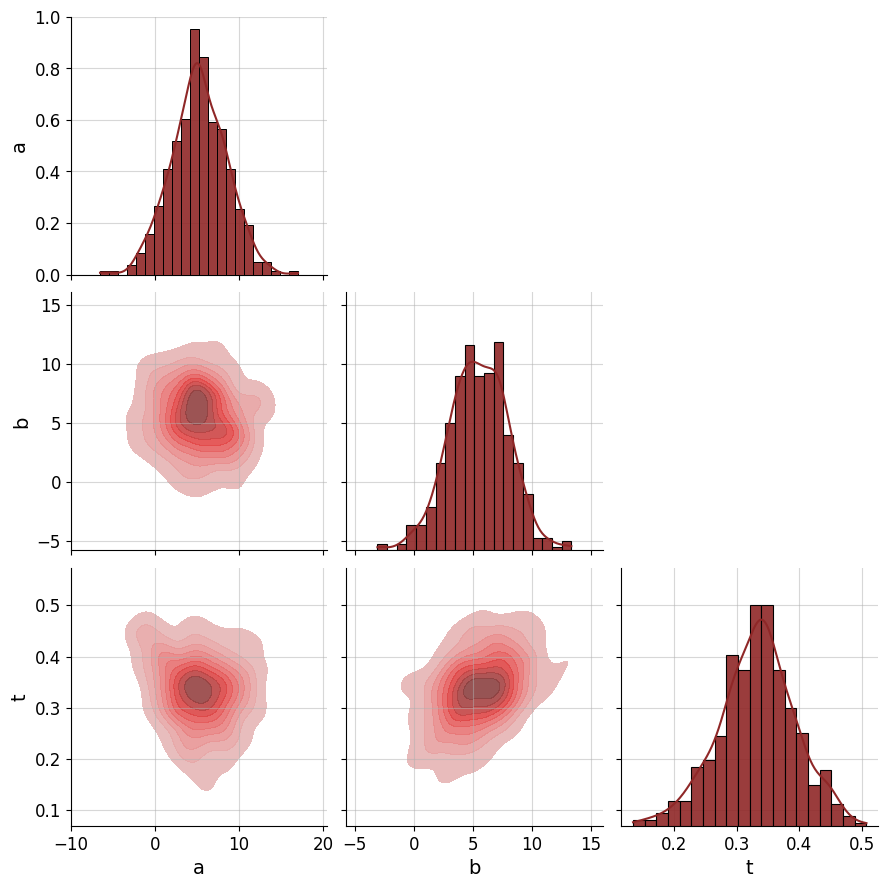

In [121]:
f = diag.plot_posterior_2d(post_samples, param_names=prior.param_names)

In [124]:
# # Generate some validation data
# validation_sims = trainer.configurator(model(batch_size=10))

# # Generate posterior draws for all simulations
# post_samples = amortizer.sample(validation_sims, n_samples=100)

In [125]:
# f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

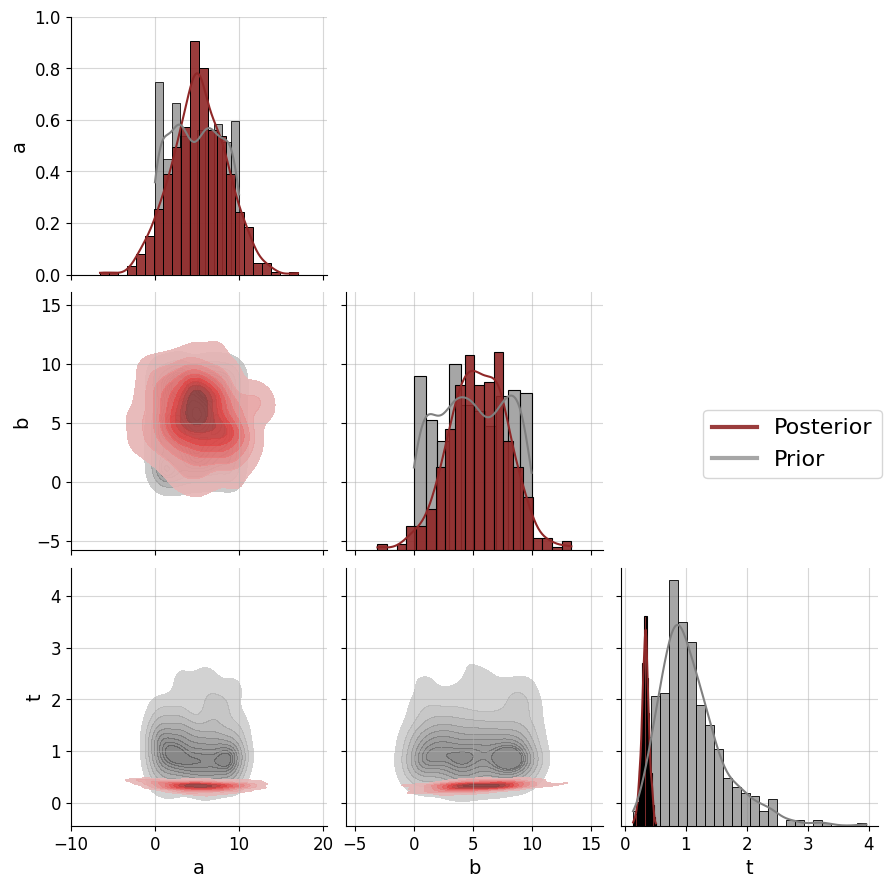

In [117]:
f = diag.plot_posterior_2d(post_samples, prior=prior)

In [118]:
post_samples.mean(axis=0)

array([5.23010442, 5.50000674, 0.33280922])

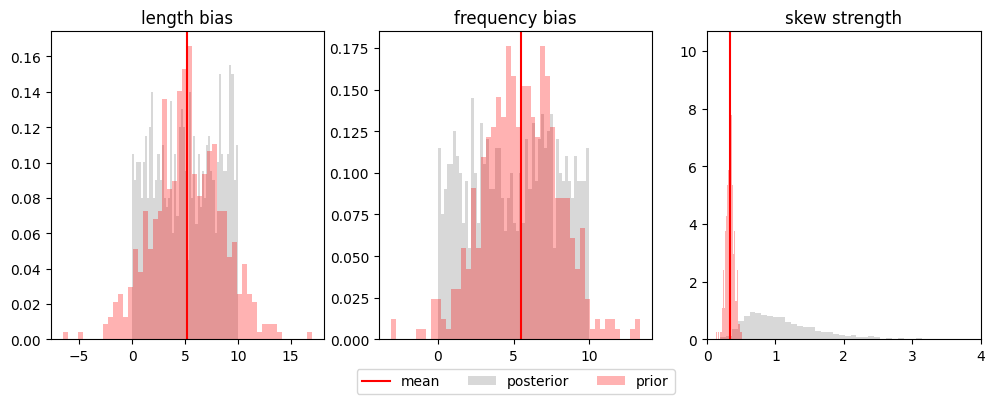

In [126]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[1].hist(np.random.uniform(0, 10, 1000), bins=50, alpha=0.3, color='grey', density=True)
axs[2].hist(np.random.lognormal(0, sigma=0.5, size=1000), bins=50, alpha=0.3, color='grey', density=True)

# Plot posteriors
axs[0].hist(post_samples[:, 0], bins=50, alpha=0.3, color='red', density=True)
axs[1].hist(post_samples[:, 1], bins=50, alpha=0.3, color='red', density=True)
axs[2].hist(post_samples[:, 2], bins=50, alpha=0.3, color='red', density=True)

# plot posterior means
axs[0].axvline(post_samples[:, 0].mean(), color='red')
axs[1].axvline(post_samples[:, 1].mean(), color='red')
axs[2].axvline(post_samples[:, 2].mean(), color='red')

# Set xlim for [2] to 0, 4
axs[2].set_xlim(0, 4)

# Set titles
axs[0].set_title('length bias')
axs[1].set_title('frequency bias')
axs[2].set_title('skew strength')

# Add legend below the subplots
plt.legend(['mean', 'posterior', 'prior'], bbox_to_anchor=(-0.7, -0.2), loc='lower center', ncol=3)

# Show the plot
plt.show()